# MRI Demand Modelling by Continuous Age – All Pathways

This notebook explores age-based modelling of MRI scan demand across England, using population-weighted estimates at the Lower Layer Super Output Area (LSOA) level. The analysis focuses on continuous age values under 85 years to capture clinically meaningful variation in diagnostic imaging utilisation, while avoiding sparse and noisy tail distributions in older populations.
We develop and evaluate a range of statistical and machine learning approaches—including Poisson Generalised Linear Models (GLMs), Random Forest regressors, and ensemble models—to estimate MRI demand per 1,000 population. Models are trained and validated using age-specific MRI usage data derived from aggregated NHS sources, joined to ONS mid-year population estimates.
This work supports geospatial and diagnostic service planning in the NHS by generating age-calibrated MRI demand curves that can be scaled and applied across regions. Future extensions may incorporate interaction effects, modality-specific subcategories, temporal projections, and LSOA-level covariates (e.g., Index of Multiple Deprivation, rural–urban classification, or proximity to imaging sites).

In [1]:
# ---- Step 0: Setup and Imports ----

import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Optional: Install pygam if missing
try:
    from pygam import LinearGAM, s, f
except ImportError:
    !{sys.executable} -m pip install pygam
    from pygam import LinearGAM, s, f

# Global config
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [2]:
# ---- Step 1: Load Raw Input Files and Preview ----

# Define paths
BASE_PATH = (
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/"
    "nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed"
)

MRI_PATH = os.path.join(BASE_PATH, "mri_master.csv")
MODALITY_COUNTS_PATH = os.path.join(BASE_PATH, "modality_procedure_counts_by_age_band_2024.csv")
POPULATION_PATH = os.path.join(BASE_PATH, "south_west_population_2024.csv")

# Load CSV files
mri_master_df = pd.read_csv(MRI_PATH)
modality_counts_df = pd.read_csv(MODALITY_COUNTS_PATH)
population_df = pd.read_csv(POPULATION_PATH)

# Preview key dataframes
for name, df in {
    "MRI Master": mri_master_df,
    "Modality Counts (2024)": modality_counts_df,
    "Population (2024)": population_df,
}.items():
    print(f"\n{name} — shape: {df.shape}")
    print(df.head())



MRI Master — shape: (324893, 30)
  icb_code                icb_name  lsoa_code  \
0      11X  NHS SOMERSET ICB - 11X  E01029036   
1      11X  NHS SOMERSET ICB - 11X  E01014470   
2      11X  NHS SOMERSET ICB - 11X  E01032629   
3      11X  NHS SOMERSET ICB - 11X  E01032627   
4      11X  NHS SOMERSET ICB - 11X  E01029271   

                          nhs_region site_code  \
0                                NaN     NTPH1   
1    Head structure (body structure)     RH504   
2    Limb structure (body structure)     RH5A8   
3    Head structure (body structure)     RH5A8   
4  Pelvic structure (body structure)     RH5A8   

                                           site_name provider_code  \
0  PRACTICE PLUS GROUP HOSPITAL - SHEPTON MALLET ...           NTP   
1                     GREENFIELDS DAY CENTRE (RH504)           RH5   
2                     MUSGROVE PARK HOSPITAL (RH5A8)           RH5   
3                     MUSGROVE PARK HOSPITAL (RH5A8)           RH5   
4                   

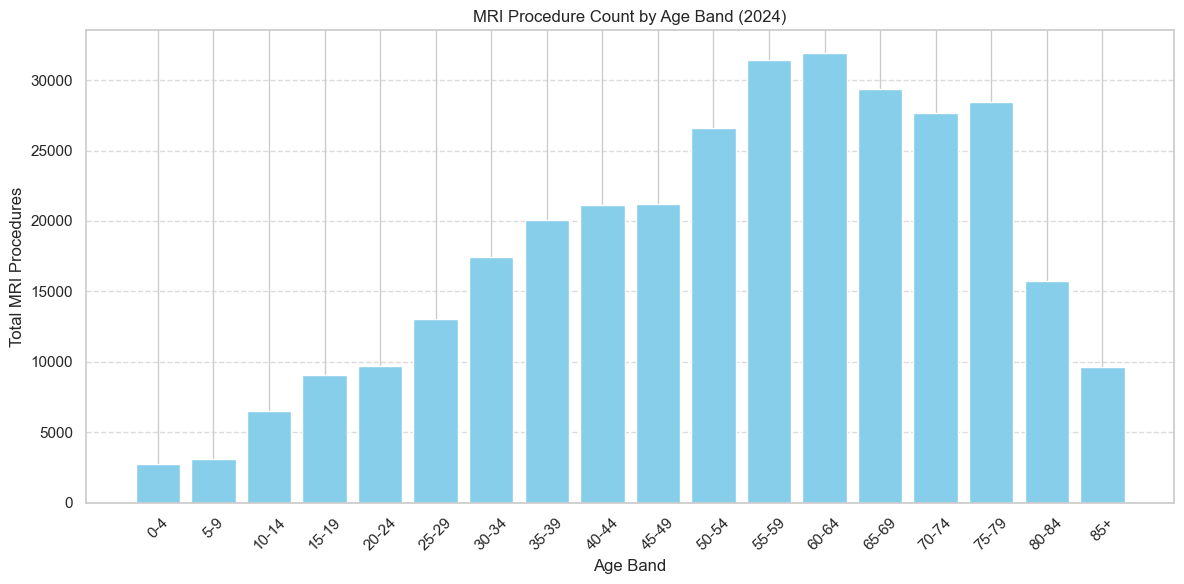

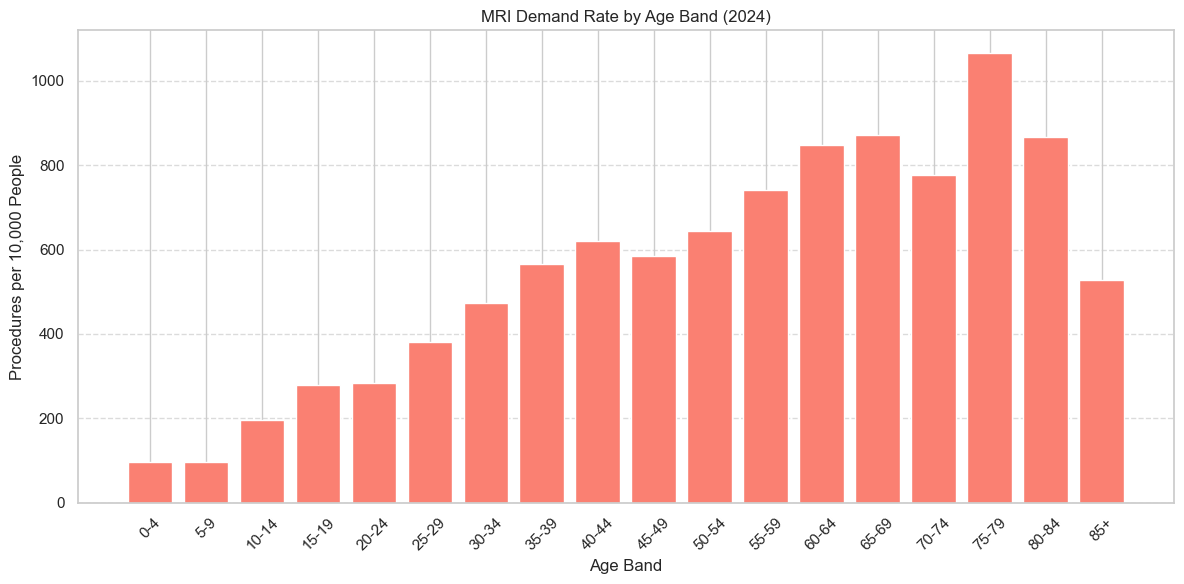

Sum of PDF (should equal 1.0): 1.000000


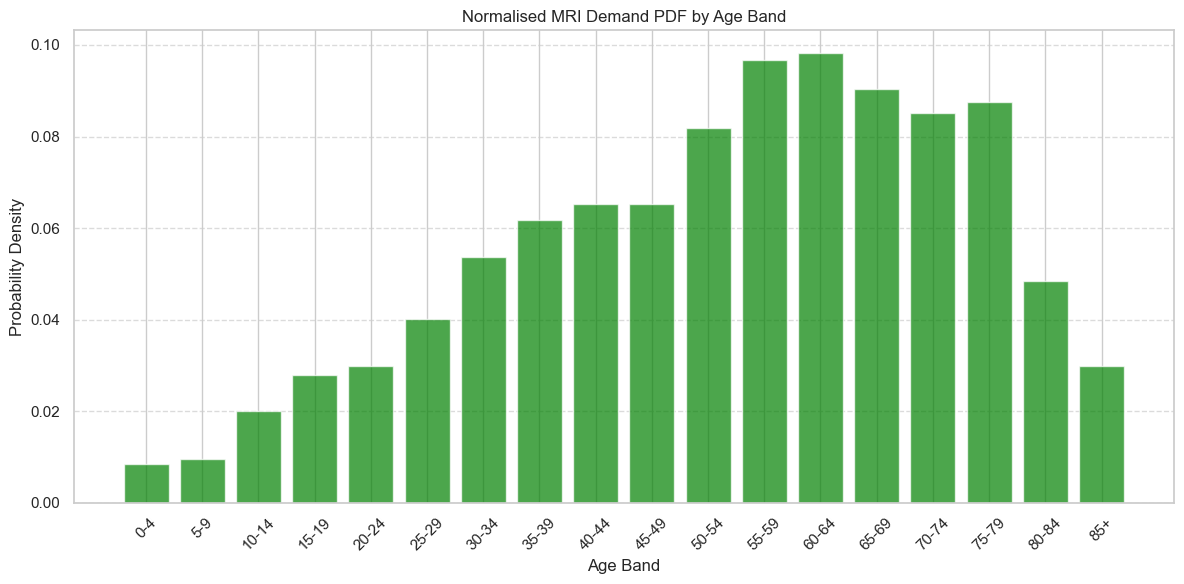

In [3]:
# ---- Step 2: Naïve MRI Demand Model by Age Band (Aggregate) ----

# Define population by age band (2024 projection)
age_band_population = pd.DataFrame({
    "age_band": [
        "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
        "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74",
        "75-79", "80-84", "85+"
    ],
    "population_2024": [
        283792, 322018, 331416, 324765, 342425, 342688, 367510, 355513,
        341210, 362553, 413048, 423510, 376552, 337298, 357074,
        266939, 181501, 183436
    ]
})

# Merge MRI totals with age-band population
mri_df = modality_counts_df[["age_band", "MRI_Total"]].copy()
mri_df = mri_df.merge(age_band_population, on="age_band", how="left")

# Calculate demand rates
mri_df["mri_demand_per_10k"] = (mri_df["MRI_Total"] / mri_df["population_2024"]) * 10000
mri_df["mri_demand_per_1k"] = (mri_df["MRI_Total"] / mri_df["population_2024"]) * 1000

# Round for readability
mri_df[["mri_demand_per_10k", "mri_demand_per_1k"]] = mri_df[
    ["mri_demand_per_10k", "mri_demand_per_1k"]
].round(2)

# ---- Visualisation: Total MRI Volumes by Age Band ----

plt.figure(figsize=(12, 6))
plt.bar(mri_df["age_band"], mri_df["MRI_Total"], color="skyblue")
plt.xlabel("Age Band")
plt.ylabel("Total MRI Procedures")
plt.title("MRI Procedure Count by Age Band (2024)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# ---- Visualisation: Demand Rate per 10,000 People ----

plt.figure(figsize=(12, 6))
plt.bar(mri_df["age_band"], mri_df["mri_demand_per_10k"], color="salmon")
plt.xlabel("Age Band")
plt.ylabel("Procedures per 10,000 People")
plt.title("MRI Demand Rate by Age Band (2024)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# ---- Generate Normalised Probability Density Function (PDF) ----

mri_df["total_demand"] = (mri_df["mri_demand_per_1k"] * mri_df["population_2024"]) / 1000
total_demand_sum = mri_df["total_demand"].sum()
mri_df["demand_pdf"] = mri_df["total_demand"] / total_demand_sum

print(f"Sum of PDF (should equal 1.0): {mri_df['demand_pdf'].sum():.6f}")

# ---- Visualisation: MRI Demand PDF by Age Band ----

plt.figure(figsize=(12, 6))
plt.bar(mri_df["age_band"], mri_df["demand_pdf"], alpha=0.7, color="green")
plt.xlabel("Age Band")
plt.ylabel("Probability Density")
plt.title("Normalised MRI Demand PDF by Age Band")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


Age column dtype: float64
Missing age values: 8
count    324885.000000
mean         53.741699
std          20.045638
min           0.000000
25%          39.000000
50%          56.000000
75%          70.000000
max         109.000000
Name: age, dtype: float64


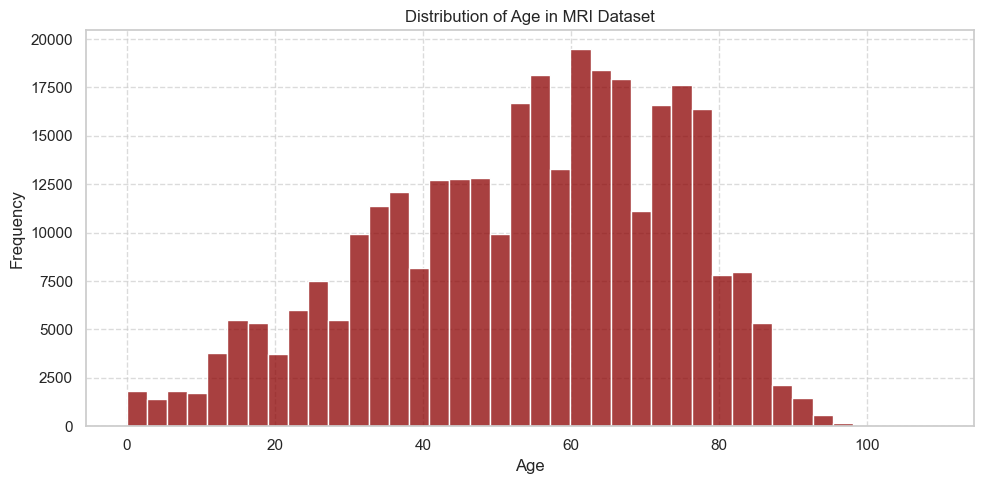

In [4]:
# ---- Step 3A: MRI Demand Model by Continuous Age (0–100) ----

# Filter only MRI records
mri_df_cont = mri_master_df[mri_master_df["is_mri"] == 1].copy()

# ---- Sanity Check: Age Field ----

# Check type, nulls, and descriptive stats
print("Age column dtype:", mri_df_cont["age"].dtype)
print("Missing age values:", mri_df_cont["age"].isna().sum())
print(mri_df_cont["age"].describe())

# Check age value distribution
plt.figure(figsize=(10, 5))
sns.histplot(mri_df_cont["age"].dropna(), bins=40, kde=False, color="darkred")
plt.title("Distribution of Age in MRI Dataset")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


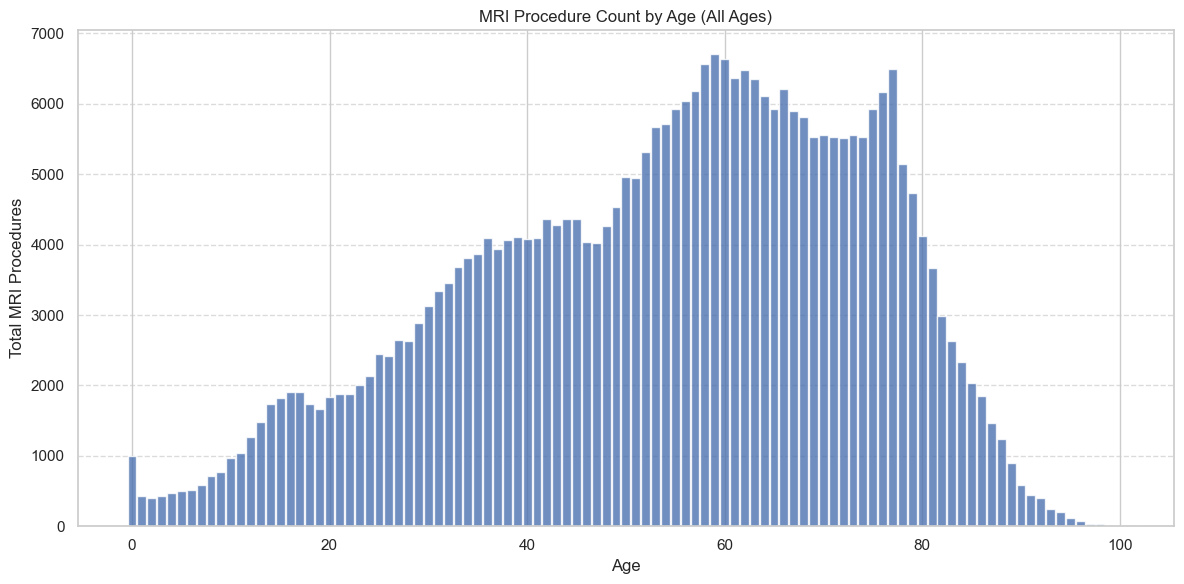

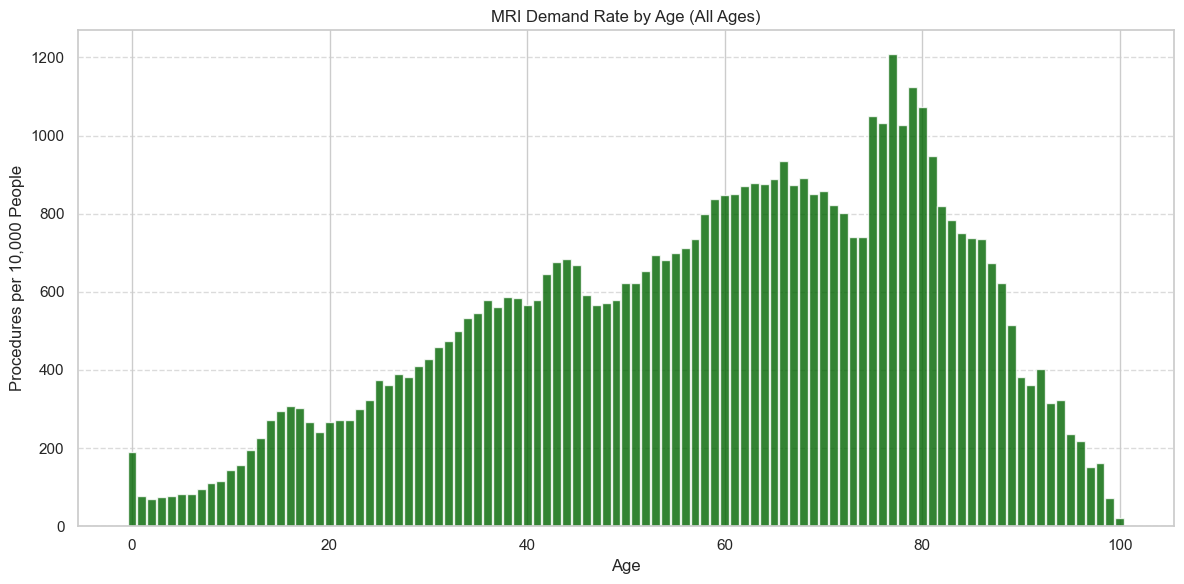

In [5]:
# ---- Step 3A (continued): Calculate MRI Demand per Age ----

# Drop rows with missing age or population
mri_df_cont = mri_df_cont.dropna(subset=["age"])
population_df = pd.read_csv(POPULATION_PATH)
population_df.rename(columns={"population": "population_2024"}, inplace=True)

# Ensure age is integer for grouping
mri_df_cont["age"] = mri_df_cont["age"].astype(int)

# Step 1: Count total MRI procedures by age
mri_by_age = (
    mri_df_cont.groupby("age")
    .size()
    .reset_index(name="MRI_Total")
)

# Step 2: Merge with population
merged_df = mri_by_age.merge(population_df, on="age", how="left")
merged_df.dropna(subset=["population_2024"], inplace=True)

# Step 3: Calculate MRI demand rates
merged_df["mri_demand_per_1k"] = (merged_df["MRI_Total"] / merged_df["population_2024"]) * 1000
merged_df["mri_demand_per_10k"] = (merged_df["MRI_Total"] / merged_df["population_2024"]) * 10000

# Step 4: Round for readability
merged_df[["mri_demand_per_1k", "mri_demand_per_10k"]] = merged_df[
    ["mri_demand_per_1k", "mri_demand_per_10k"]
].round(2)

# Step 5: Sort by age
merged_df.sort_values("age", inplace=True)

# ---- Visualise: MRI Procedure Volume by Age ----

plt.figure(figsize=(12, 6))
plt.bar(merged_df["age"], merged_df["MRI_Total"], width=0.9, alpha=0.8)
plt.xlabel("Age")
plt.ylabel("Total MRI Procedures")
plt.title("MRI Procedure Count by Age (All Ages)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# ---- Visualise: Demand Rate per 10,000 by Age ----

plt.figure(figsize=(12, 6))
plt.bar(merged_df["age"], merged_df["mri_demand_per_10k"], width=0.9, alpha=0.8, color="darkgreen")
plt.xlabel("Age")
plt.ylabel("Procedures per 10,000 People")
plt.title("MRI Demand Rate by Age (All Ages)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


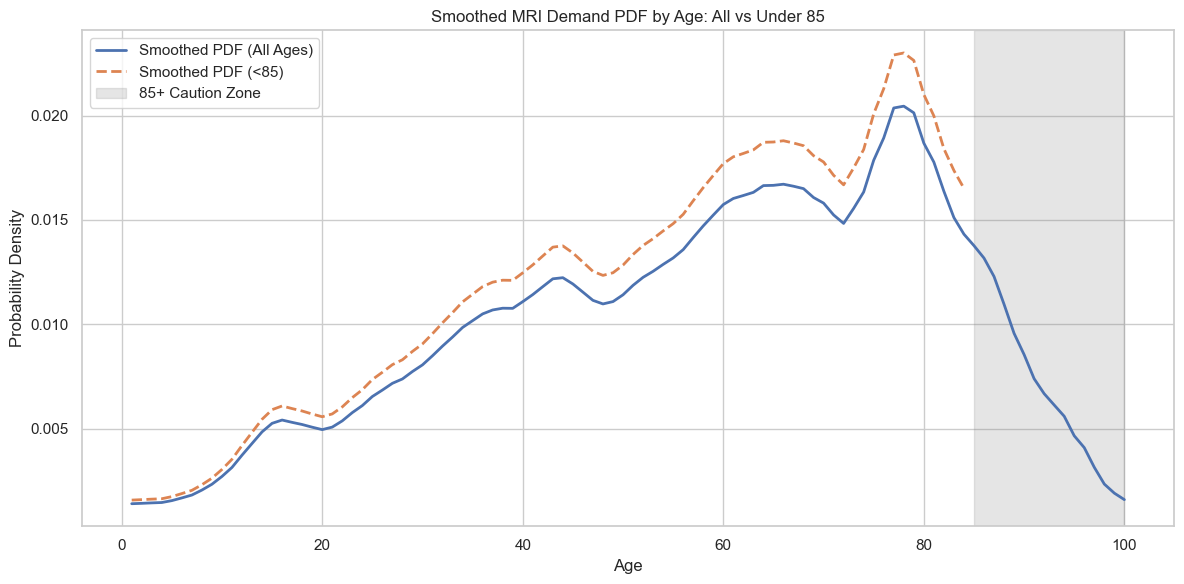

In [6]:
# ---- Step 3A.1: PDF Generation and Smoothing ----

# Full age range 1–100+
full_age_range = pd.DataFrame({"age": np.arange(1, 101)})
merged_full = full_age_range.merge(
    merged_df[["age", "mri_demand_per_1k"]],
    on="age",
    how="left"
)
merged_full["mri_demand_per_1k"].fillna(0, inplace=True)

# PDF and smoothing (all ages)
demand_all = merged_full["mri_demand_per_1k"].values
pdf_all = demand_all / demand_all.sum()
merged_full["pdf_all"] = pdf_all
merged_full["pdf_all_smoothed"] = merged_full["pdf_all"].rolling(
    window=5, center=True, min_periods=1
).mean()

# PDF and smoothing (<85 subset)
subset_df = merged_full[merged_full["age"] < 85].copy()
demand_sub = subset_df["mri_demand_per_1k"].values
pdf_sub = demand_sub / demand_sub.sum()
subset_df["pdf_sub"] = pdf_sub
subset_df["pdf_sub_smoothed"] = subset_df["pdf_sub"].rolling(
    window=5, center=True, min_periods=1
).mean()

# ---- Visualise: All Ages vs <85 Smoothed PDFs ----

plt.figure(figsize=(12, 6))
plt.plot(
    merged_full["age"], merged_full["pdf_all_smoothed"],
    label="Smoothed PDF (All Ages)", linewidth=2
)
plt.plot(
    subset_df["age"], subset_df["pdf_sub_smoothed"],
    label="Smoothed PDF (<85)", linewidth=2, linestyle="--"
)
plt.xlabel("Age")
plt.ylabel("Probability Density")
plt.title("Smoothed MRI Demand PDF by Age: All vs Under 85")
plt.axvspan(85, 100, color='grey', alpha=0.2, label="85+ Caution Zone")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


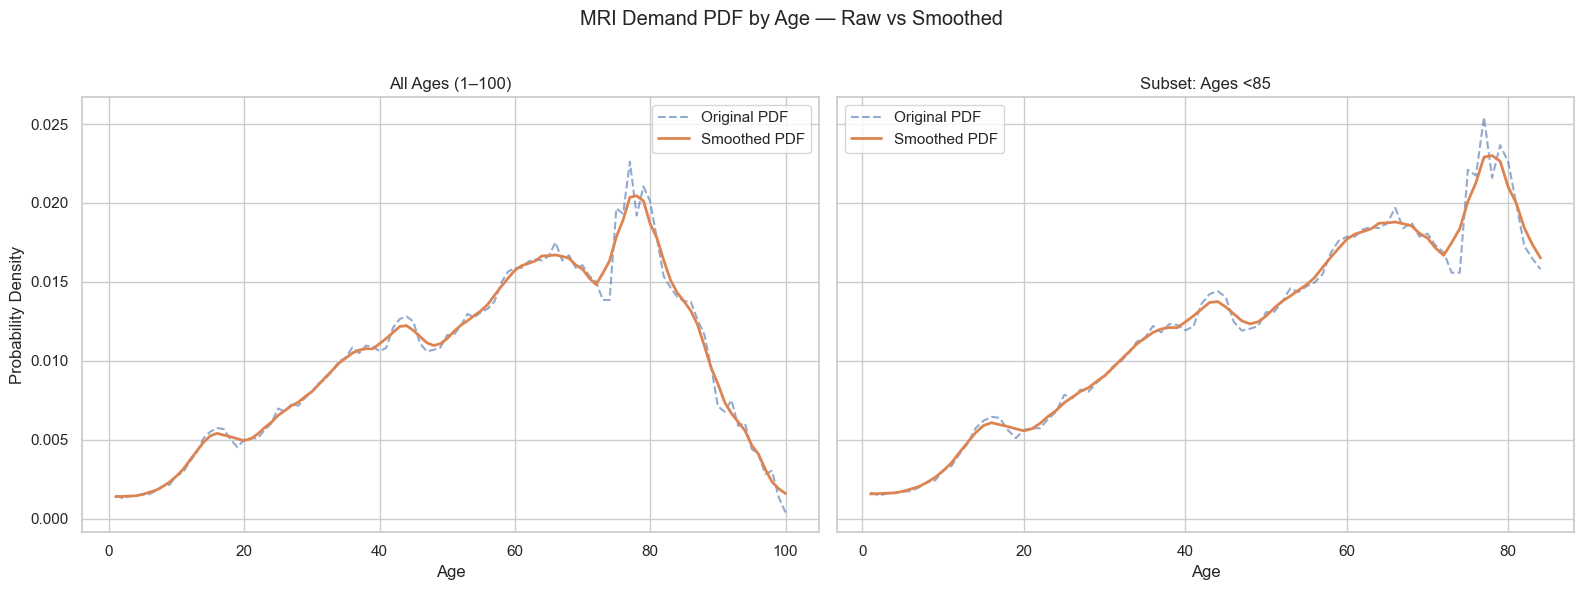

In [7]:
# ---- Step 3A.2: Apply Moving Average Smoothing to PDFs ----

# Define rolling window size
window_size = 5

# Smooth full-age PDF
merged_full["pdf_all_smoothed"] = merged_full["pdf_all"].rolling(
    window=window_size, center=True, min_periods=1
).mean()

# Smooth <85 PDF
subset_df["pdf_sub_smoothed"] = subset_df["pdf_sub"].rolling(
    window=window_size, center=True, min_periods=1
).mean()

# ---- Side-by-Side Plot: Raw vs Smoothed PDFs (All Ages) ----

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Panel A: All Ages
ax[0].plot(
    merged_full["age"], merged_full["pdf_all"],
    label="Original PDF", alpha=0.6, linestyle="--"
)
ax[0].plot(
    merged_full["age"], merged_full["pdf_all_smoothed"],
    label="Smoothed PDF", linewidth=2
)
ax[0].set_title("All Ages (1–100)")
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Probability Density")
ax[0].legend()
ax[0].grid(True)

# Panel B: Subset <85
ax[1].plot(
    subset_df["age"], subset_df["pdf_sub"],
    label="Original PDF", alpha=0.6, linestyle="--"
)
ax[1].plot(
    subset_df["age"], subset_df["pdf_sub_smoothed"],
    label="Smoothed PDF", linewidth=2
)
ax[1].set_title("Subset: Ages <85")
ax[1].set_xlabel("Age")
ax[1].legend()
ax[1].grid(True)

plt.suptitle("MRI Demand PDF by Age — Raw vs Smoothed")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [8]:
# ---- Optional: Output MRI Demand PDF Tables ----

# Preview smoothed MRI demand PDF (full age)
print("Smoothed MRI PDF – All Ages (tail):")
print(merged_full[["age", "mri_demand_per_1k", "pdf_all_smoothed"]].tail())

# Preview smoothed MRI demand PDF (<85)
print("\nSmoothed MRI PDF – Age <85 (tail):")
print(subset_df[["age", "mri_demand_per_1k", "pdf_sub_smoothed"]].tail())


Smoothed MRI PDF – All Ages (tail):
    age  mri_demand_per_1k  pdf_all_smoothed
95   96              21.80          0.004083
96   97              15.15          0.003141
97   98              16.22          0.002337
98   99               7.18          0.001901
99  100               2.11          0.001591

Smoothed MRI PDF – Age <85 (tail):
    age  mri_demand_per_1k  pdf_sub_smoothed
79   80             107.40          0.021009
80   81              94.74          0.019985
81   82              82.04          0.018413
82   83              78.31          0.017368
83   84              75.12          0.016513


In [9]:
# ---- Step 4.1: Fit GLM and Random Forest Models ----

# Prepare modelling dataframe
model_df = merged_full.copy()
model_df = model_df.dropna(subset=["mri_demand_per_1k"])
model_df = model_df[model_df["age"] <= 100]

# Fit Poisson GLM using statsmodels
glm_model = smf.glm(
    formula="mri_demand_per_1k ~ age",
    data=model_df,
    family=sm.families.Poisson()
).fit()

# Store GLM predictions
model_df["predicted_glm"] = glm_model.predict(model_df)

# Fit Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(model_df[["age"]], model_df["mri_demand_per_1k"])
model_df["predicted_rf"] = rf_model.predict(model_df[["age"]])

# ---- Step 4.2: GLM Confidence Intervals ----

pred_summary = glm_model.get_prediction(model_df).summary_frame(alpha=0.05)
model_df["glm_ci_lower"] = pred_summary["mean_ci_lower"]
model_df["glm_ci_upper"] = pred_summary["mean_ci_upper"]

# ---- Step 4.3: Ensemble and Smoothing (Rolling Avg) ----

# Weighted average
model_df["predicted_ensemble"] = (
    0.6 * model_df["predicted_glm"] + 0.4 * model_df["predicted_rf"]
)

# Apply moving average smoothing (window = 5)
for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
    model_df[f"{col}_smoothed"] = model_df[col].rolling(
        window=5, center=True, min_periods=1
    ).mean()

# Smooth CIs for visual consistency
model_df["glm_ci_lower_smoothed"] = model_df["glm_ci_lower"].rolling(
    window=5, center=True, min_periods=1
).mean()
model_df["glm_ci_upper_smoothed"] = model_df["glm_ci_upper"].rolling(
    window=5, center=True, min_periods=1
).mean()

# ---- Step 4.4: Evaluate All Models ----

def evaluate(true, pred, name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"{name:<30} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

evaluate(model_df["mri_demand_per_1k"], model_df["predicted_glm_smoothed"], "Poisson GLM (Smoothed)")
evaluate(model_df["mri_demand_per_1k"], model_df["predicted_rf_smoothed"], "Random Forest (Smoothed)")
evaluate(model_df["mri_demand_per_1k"], model_df["predicted_ensemble_smoothed"], "Ensemble (Smoothed)")


Poisson GLM (Smoothed)         | MAE: 21.05 | RMSE: 26.71 | R²: 0.163
Random Forest (Smoothed)       | MAE: 2.16 | RMSE: 3.43 | R²: 0.986
Ensemble (Smoothed)            | MAE: 12.75 | RMSE: 16.55 | R²: 0.679


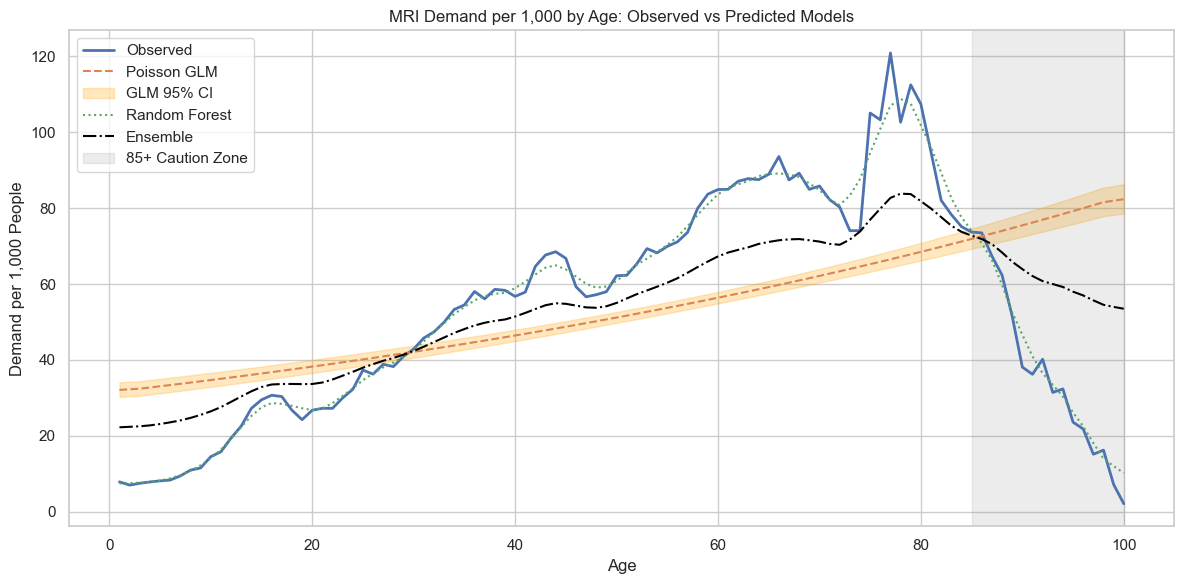

In [10]:
# ---- Step 4.5: Observed vs Predicted Visualisation ----

plt.figure(figsize=(12, 6))

# Observed values
sns.lineplot(data=model_df, x="age", y="mri_demand_per_1k", label="Observed", linewidth=2)

# GLM (smoothed)
sns.lineplot(data=model_df, x="age", y="predicted_glm_smoothed", label="Poisson GLM", linestyle="--")

# GLM CI
plt.fill_between(
    model_df["age"],
    model_df["glm_ci_lower_smoothed"],
    model_df["glm_ci_upper_smoothed"],
    color="orange", alpha=0.25, label="GLM 95% CI"
)

# RF and Ensemble
sns.lineplot(data=model_df, x="age", y="predicted_rf_smoothed", label="Random Forest", linestyle=":")
sns.lineplot(data=model_df, x="age", y="predicted_ensemble_smoothed", label="Ensemble", linestyle="-.", color="black")

plt.axvspan(85, 100, color='grey', alpha=0.15, label="85+ Caution Zone")
plt.title("MRI Demand per 1,000 by Age: Observed vs Predicted Models")
plt.xlabel("Age")
plt.ylabel("Demand per 1,000 People")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# ---- Step 5.1: Filter Age <85 and Refit Models ----

# Filter age <85 only
model_sub_df = model_df[model_df["age"] < 85].copy()

# Fit Poisson GLM
glm_model_sub = smf.glm(
    formula="mri_demand_per_1k ~ age",
    data=model_sub_df,
    family=sm.families.Poisson()
).fit()
model_sub_df["predicted_glm"] = glm_model_sub.predict(model_sub_df)

# Fit Random Forest
rf_model_sub = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_sub.fit(model_sub_df[["age"]], model_sub_df["mri_demand_per_1k"])
model_sub_df["predicted_rf"] = rf_model_sub.predict(model_sub_df[["age"]])

# ---- Step 5.2: GLM CI + Ensemble for <85 ----

pred_summary_sub = glm_model_sub.get_prediction(model_sub_df).summary_frame(alpha=0.05)
model_sub_df["glm_ci_lower"] = pred_summary_sub["mean_ci_lower"]
model_sub_df["glm_ci_upper"] = pred_summary_sub["mean_ci_upper"]

# Ensemble prediction
model_sub_df["predicted_ensemble"] = (
    0.6 * model_sub_df["predicted_glm"] + 0.4 * model_sub_df["predicted_rf"]
)

# Smooth predictions and CI (window = 5)
for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
    model_sub_df[f"{col}_smoothed"] = model_sub_df[col].rolling(
        window=5, center=True, min_periods=1
    ).mean()

model_sub_df["glm_ci_lower_smoothed"] = model_sub_df["glm_ci_lower"].rolling(
    window=5, center=True, min_periods=1
).mean()
model_sub_df["glm_ci_upper_smoothed"] = model_sub_df["glm_ci_upper"].rolling(
    window=5, center=True, min_periods=1
).mean()

# ---- Step 5.3: Evaluate Models for Age <85 ----

print("Model Evaluation: Age <85 Only\n")
evaluate(model_sub_df["mri_demand_per_1k"], model_sub_df["predicted_glm_smoothed"], "Poisson GLM (<85)")
evaluate(model_sub_df["mri_demand_per_1k"], model_sub_df["predicted_rf_smoothed"], "Random Forest (<85)")
evaluate(model_sub_df["mri_demand_per_1k"], model_sub_df["predicted_ensemble_smoothed"], "Ensemble (<85)")


Model Evaluation: Age <85 Only

Poisson GLM (<85)              | MAE: 9.36 | RMSE: 12.21 | R²: 0.826
Random Forest (<85)            | MAE: 2.06 | RMSE: 3.46 | R²: 0.986
Ensemble (<85)                 | MAE: 6.15 | RMSE: 8.21 | R²: 0.921


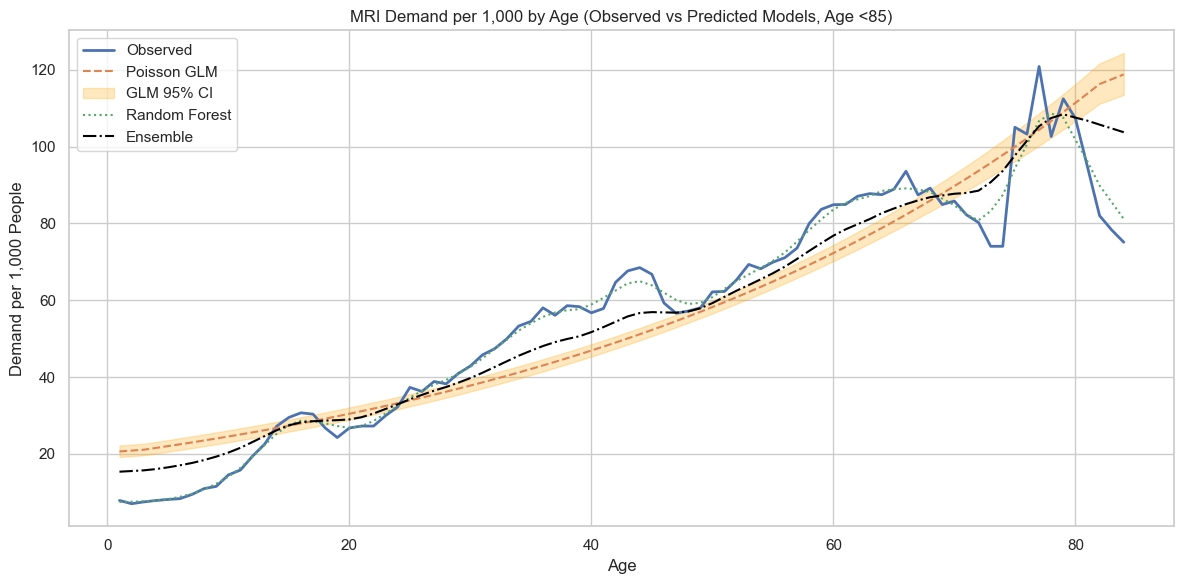

In [12]:
# ---- Step 5.4: Observed vs Predicted Plot for Age <85 ----

plt.figure(figsize=(12, 6))

sns.lineplot(data=model_sub_df, x="age", y="mri_demand_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_sub_df, x="age", y="predicted_glm_smoothed", label="Poisson GLM", linestyle="--")

plt.fill_between(
    model_sub_df["age"],
    model_sub_df["glm_ci_lower_smoothed"],
    model_sub_df["glm_ci_upper_smoothed"],
    color="orange", alpha=0.25, label="GLM 95% CI"
)

sns.lineplot(data=model_sub_df, x="age", y="predicted_rf_smoothed", label="Random Forest", linestyle=":")
sns.lineplot(data=model_sub_df, x="age", y="predicted_ensemble_smoothed", label="Ensemble", linestyle="-.", color="black")

plt.title("MRI Demand per 1,000 by Age (Observed vs Predicted Models, Age <85)")
plt.xlabel("Age")
plt.ylabel("Demand per 1,000 People")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# ---- Step 6.1: Prepare Data for Interaction Model ----

# Re-filter only MRI rows with valid values
mri_df_int = mri_master_df[mri_master_df["is_mri"] == 1].copy()
mri_df_int = mri_df_int.dropna(subset=["age", "cancer_flag", "patient_source"])
mri_df_int["age"] = mri_df_int["age"].astype(int)
mri_df_int["cancer_flag"] = mri_df_int["cancer_flag"].astype(str)  # ensure string for GLM
mri_df_int["patient_source"] = mri_df_int["patient_source"].astype("category")

# Load population data
population_df = pd.read_csv(POPULATION_PATH)
population_df.rename(columns={"population": "population_2024"}, inplace=True)

# Count MRI procedures by age, cancer_flag, patient_source
grouped_df = (
    mri_df_int.groupby(["age", "cancer_flag", "patient_source"])
    .size()
    .reset_index(name="MRI_Total")
)

# Merge population
grouped_df = grouped_df.merge(population_df, on="age", how="left")
grouped_df.dropna(subset=["population_2024"], inplace=True)

# Compute demand rate per 1,000 people
grouped_df["mri_demand_per_1k"] = (grouped_df["MRI_Total"] / grouped_df["population_2024"]) * 1000

# ---- Step 6.2: Fit GLM with Interaction: age × cancer_flag ----

interaction_formula = "mri_demand_per_1k ~ age * C(cancer_flag) + C(patient_source)"

glm_interaction = smf.glm(
    formula=interaction_formula,
    data=grouped_df,
    family=sm.families.Poisson()
).fit()

# Print GLM summary
print(glm_interaction.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:      mri_demand_per_1k   No. Observations:                 1414
Model:                            GLM   Df Residuals:                     1404
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2539.5
Date:                Mon, 07 Jul 2025   Deviance:                       2386.6
Time:                        15:49:50   Pearson chi2:                 2.19e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9997
Covariance Type:            nonrobust                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In [14]:
def compute_mri_demand_per_1k(modality_counts_df, population_dict):
    """
    Compute MRI demand per 1,000 people by ONS age bands.

    Parameters:
    - modality_counts_df: DataFrame with MRI counts by age_band (must include 'age_band' and 'MRI_Total')
    - population_dict: Dictionary mapping age_band to 2024 population estimates

    Returns:
    - DataFrame with age_band, MRI_Total, population_2024, mri_demand_per_1k, and normalised demand PDF
    """
    df = modality_counts_df[["age_band", "MRI_Total"]].copy()
    df["population_2024"] = df["age_band"].map(population_dict)
    df.dropna(inplace=True)

    # Calculate demand per 1,000
    df["mri_demand_per_1k"] = (df["MRI_Total"] / df["population_2024"]) * 1000

    # Calculate normalised demand PDF (proportional to population × rate)
    df["total_demand"] = (df["mri_demand_per_1k"] * df["population_2024"]) / 1000
    total_demand_sum = df["total_demand"].sum()
    df["demand_pdf"] = df["total_demand"] / total_demand_sum

    return df

# Define dictionary of ONS age-band population estimates
age_band_population = {
    "0-4": 283792, "5-9": 322018, "10-14": 331416, "15-19": 324765,
    "20-24": 342425, "25-29": 342688, "30-34": 367510, "35-39": 355513,
    "40-44": 341210, "45-49": 362553, "50-54": 413048, "55-59": 423510,
    "60-64": 376552, "65-69": 337298, "70-74": 357074, "75-79": 266939,
    "80-84": 181501, "85+": 183436
}




In [15]:
# Apply function
mri_demand_df = compute_mri_demand_per_1k(modality_counts_df, age_band_population)
mri_demand_df.head()

,age_band,MRI_Total,population_2024,mri_demand_per_1k,total_demand,demand_pdf
0,0-4,2724,283792,9.598579,2724.0,0.008385
1,5-9,3093,322018,9.605053,3093.0,0.009520
2,10-14,6485,331416,19.567553,6485.0,0.019961
3,15-19,9043,324765,27.844749,9043.0,0.027834
4,20-24,9728,342425,28.409141,9728.0,0.029943


In [16]:
def fit_mri_glm_under85(df, age_col="age", demand_col="mri_demand_per_1k", window=5):
    """
    Fit a Poisson GLM to MRI demand per 1,000 for ages <85.
    Includes confidence intervals, ensemble with Random Forest, and smoothing.

    Parameters:
    - df: DataFrame with 'age' and 'mri_demand_per_1k' columns
    - age_col: Name of the age column
    - demand_col: Name of the demand column
    - window: Smoothing window (e.g., 5-year rolling average)

    Returns:
    - df_result: DataFrame with smoothed predictions and CIs
    - glm_model: Fitted Poisson GLM
    - rf_model: Fitted Random Forest model
    """
    from sklearn.ensemble import RandomForestRegressor
    import statsmodels.formula.api as smf

    # Filter to age < 85
    df_sub = df[df[age_col] < 85].copy()

    # Fit GLM
    glm_model = smf.glm(
        formula=f"{demand_col} ~ {age_col}",
        data=df_sub,
        family=sm.families.Poisson()
    ).fit()
    df_sub["predicted_glm"] = glm_model.predict(df_sub)

    # GLM CI
    ci = glm_model.get_prediction(df_sub).summary_frame(alpha=0.05)
    df_sub["glm_ci_lower"] = ci["mean_ci_lower"]
    df_sub["glm_ci_upper"] = ci["mean_ci_upper"]

    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(df_sub[[age_col]], df_sub[demand_col])
    df_sub["predicted_rf"] = rf_model.predict(df_sub[[age_col]])

    # Ensemble
    df_sub["predicted_ensemble"] = 0.6 * df_sub["predicted_glm"] + 0.4 * df_sub["predicted_rf"]

    # Smoothing
    for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
        df_sub[f"{col}_smoothed"] = df_sub[col].rolling(window=window, center=True, min_periods=1).mean()

    df_sub["glm_ci_lower_smoothed"] = df_sub["glm_ci_lower"].rolling(window=window, center=True, min_periods=1).mean()
    df_sub["glm_ci_upper_smoothed"] = df_sub["glm_ci_upper"].rolling(window=window, center=True, min_periods=1).mean()

    return df_sub, glm_model, rf_model



In [17]:
# Use merged_full from earlier (contains age and mri_demand_per_1k)
model_input_df = merged_full.copy()
model_sub_df, glm_sub, rf_sub = fit_mri_glm_under85(model_input_df)

# Preview results
model_sub_df[["age", "mri_demand_per_1k", "predicted_glm_smoothed", "predicted_rf_smoothed"]].head()


,age,mri_demand_per_1k,predicted_glm_smoothed,predicted_rf_smoothed
0,1,7.87,20.626026,7.46450
1,2,7.02,20.853030,7.54330
2,3,7.49,21.083354,7.64572
3,4,7.85,21.544110,7.77990
4,5,8.13,22.014935,8.19532
